In [1]:
# sklearn 0.20.1 ist voraussetzung ansonsten pickle error (cannot unserialize)

In [41]:
!pip uninstall scikit-learn --yes

Uninstalling scikit-learn-0.20.1:
  Successfully uninstalled scikit-learn-0.20.1


In [42]:
!pip install scikit-learn==0.20.1

  Using cached https://files.pythonhosted.org/packages/10/26/d04320c3edf2d59b1fcd0720b46753d4d603a76e68d8ad10a9b92ab06db2/scikit_learn-0.20.1-cp36-cp36m-manylinux1_x86_64.whl


In [43]:
!pip install textblob_de

In [44]:
!pip install imblearn

In [45]:
import pickle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
with open('enriched_thomann_data.pickle', 'rb') as f:
        thomann_data = pickle.load(f)

In [47]:
def display_metric(y_true, y_pred):
    df = pd.DataFrame(np.column_stack([y_pred, y_true]), columns=["Predicted", "Truth"])
    class_mse = 0
    class_mae = 0
    print("MSE for Classes:")
    for i in df.Truth.unique():
        temp = df[df["Truth"]==i]
        mse = mean_squared_error(temp.Truth, temp.Predicted)
        mae = mean_absolute_error(temp.Truth, temp.Predicted)
        print("Class {}: MSE:{} MAE:{}".format(i, mse, mae))
        class_mse += mse
        class_mae += mae
    print()
    print("AVG MSE over Classes {}".format(class_mse/len(df.Truth.unique())))
    print("AVG MAE over Classes {}".format(class_mae/len(df.Truth.unique())))
    print()
    print("Global: MAE: {} MSE {}".format(mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred)))

In [48]:
# erstellen der eigenen Metrik
def custom_mse_metric(y_true, y_pred):
    mse_class = 0
    num_classes = len(np.unique(y_true))
    stacked = np.vstack((y_true, y_pred))
    for i in np.unique(stacked[0]):     
        y_true_temp = stacked[0][np.where(stacked[0]==i)]
        y_pred_temp = stacked[1][np.where(stacked[0]==i)]
        mse = np.mean(np.square(y_pred_temp - y_true_temp))
        mse_class += mse
    return mse_class/num_classes

custom_mse_score = make_scorer(custom_mse_metric, greater_is_better=False)

In [122]:
# funktion dient dem plotten der Modelergebnisse
def plot_results(y_test, pred_list, pred_without_neg_list, name_list):
    
    df = pd.DataFrame()
    scores = []
    scores_without_neg = []
    
    temp = pd.DataFrame()
    for i, liste in enumerate(pred_list):
        temp["Truth"] = y_test
        temp["Verfahren"] = name_list[i]
        temp["Predicted"] = liste
        scores.append(custom_mse_metric(y_test, liste))
        scores_without_neg.append(custom_mse_metric(y_test, pred_without_neg_list[i]))
        df = pd.concat([df, temp], ignore_index=True) 
        
    # plot
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(x="Truth", y="Predicted", hue="Verfahren",data=df,ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    for i, name in enumerate(name_list):
        if name_list[i]=="W2V_NN":
            name_list[i] = "{} ({} | n.A.)".format(name, np.round(scores[i], decimals=3))
        else:
            name_list[i] = "{} ({} | {})".format(name, np.round(scores[i], decimals=3), 
                                                         np.round(scores_without_neg[i], decimals=3))
        
    legend = ax.legend(handles, name_list, title="Test Error mit und ohne Negationhandling",prop={'size': 12},loc=2)
    legend.get_title().set_fontsize('12')
    ax.set_title("Vorhersagen der Modelle auf den Testdaten", fontsize=18)

### Train- Testsplit

Um die einzelnen Bewertungsklassen gleichzeitig zu verteilen wird der Parameter stratify=y gesetzt. Desweiteren werden X_train und X_test auch noch auf Basis der nicht von dem Negationshandling betroffenen Spalte review_pp_only gespeichert. Dadurch kann später geprüft werden ob das Negationshandling wirkungsvoll war.

In [50]:
# train- testsplit
y = thomann_data["stars_gesamt"]/20
y = y.astype("int64")
X = thomann_data[["review","review_pp_only"]]
num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
# erstelle X train- test auch für Daten ohne Negationshandling um Auswirkung sichtbar zu machen
X_train_pp_only = X_train["review_pp_only"]
X_test_pp_only = X_test["review_pp_only"]
# normale X train- test verwenden Reviews mit Preprocessing und Negationshandling
X_train = X_train["review"]
X_test = X_test["review"]
del X, y

## Dokument-Term-Matrix Ansatz

die nachfolgenden Codeblöcke erstellen Modelle die Dokument-Term-Matrizen zur Featuregenerierung nutzen. Dafür werden verschiedene Pipelines entwickelt die den selben Grundansatz verfolgen. Der sequentielle Ablauf ist:

> Featureerstellung -> Samplingverfahren -> Model

Die Featureerstellung erfolgt dabei immer durch den CountVectorizer und TFIDF Transformer. Für jedes Model entsteht eine gesonderte Pipeline wie für eine standardmäßige Pipeline vorgesehen. Zudem ist jedem Model genau eine Samplingmethode zugewiesen.  

### Definiere ParameterGrid

Hier werden die zu tunenden Parameter festgelegt. Die vergebene Bezeichnung vor den doppelten Unterstrich bezeichnet den Namen des Pipelineschritts. So können die Parameter den richtigen Teilschritten der Pipeline zugeordnet werden. Es entstehen außerdem verschiedene Parameter Dictionarys die dann später zusammengefügt werden. So muss man die Parameter welche in jeder Pipeline vorkommen nicht immer extra definieren. 

In [51]:
# definiere ParameterGrid 
param_basic = {
    'vect__max_df': (1.0, 0.8),
    'vect__max_features': (None, 10000),
    'vect__ngram_range': ((1,1),(1,2),(2,2)),
    'vect__binary': (True, False),
    'tfidf__use_idf': (True, False),
    
}

param_adasyn = {
    'sampl__n_neighbors': (1, 3, 5),
    'sampl__sampling_strategy': ('auto','minority')
}

param_smote = {
    'sampl__k_neighbors': (1, 3, 5, 7),
    'sampl__sampling_strategy': ('auto','minority')
}

param_rus = {
    'sampl__sampling_strategy': ('auto','majority')
}

param_ros = {
    'sampl__sampling_strategy': ('auto','minority')
}

param_lgb = {
    'reg__max_depth' : (3, 6, 12),
    'reg__learning_rate' : (0.1, 0.01),
    'reg__n_estimators' : (100, 300)
}


### Definiere Pipelines

Nun werden die eigentlichen Pipelines konstruiert. Der Ablauf dieser wurde bereits genannt. Parameter die hier angegeben werden sind fix und werden nicht getuned. 

In [52]:
pl_ROS_LGB = Pipeline([('vect', CountVectorizer()), 
                       ('tfidf', TfidfTransformer()), 
                       ('sampl', RandomOverSampler(random_state=42)), 
                       ('reg', lgb.LGBMRegressor(random_state=42, n_jobs=-1))])

In [53]:
pl_ADA_RF = Pipeline([ ('vect', CountVectorizer()), 
                       ('tfidf', TfidfTransformer()), 
                       ('sampl', ADASYN(random_state=42)), 
                       ('reg', RandomForestRegressor(random_state=42,n_jobs=-1))])

In [54]:
pl_SMOTE_Ridge = Pipeline([('vect', CountVectorizer()), 
                           ('tfidf', TfidfTransformer()), 
                           ('sampl', SMOTE(random_state=42)),
                           ('reg', Ridge(random_state=42))])

In [55]:
pl_RUS_LR = Pipeline([('vect', CountVectorizer()), 
                           ('tfidf', TfidfTransformer()),                        
                           ('sampl', RandomUnderSampler(random_state=42)),                           
                           ('reg', LinearRegression(n_jobs=-1))])

### Definiere GridSearchCV

Hier entsteht die Verknüpfung zwischen Pipeline und den zugehörigen Parametern. Dafür werden die einzelnen Parameter Dictionarys die für die Pipeline notwendig sind zusammengefügt. Außerdem wird hier auch die eigens erstellte Metrik als Scoring Objekt übergeben. Dadurch wählt GridSearchCV das beste Modell anhand der neuen Metrik. 

In [56]:
gs_ROS_LGB = GridSearchCV(pl_ROS_LGB, {**param_basic, **param_ros, **param_lgb}, scoring=custom_mse_score, cv=2, n_jobs=-1, verbose=1)

In [57]:
gs_ADA_RF = GridSearchCV(pl_ADA_RF, {**param_basic, **param_adasyn}, scoring=custom_mse_score, cv=2, n_jobs=-1, verbose=1)

In [58]:
gs_SMOTE_Ridge = GridSearchCV(pl_SMOTE_Ridge, {**param_basic, **param_smote}, scoring=custom_mse_score, cv=2, n_jobs=-1, verbose=1)

In [59]:
gs_RUS_LR = GridSearchCV(pl_RUS_LR, {**param_basic, **param_rus}, scoring=custom_mse_score, cv=2, n_jobs=-1, verbose=1)

### Fit, Predict, Pickle

In den hier vorkommenden Teilschritten wird die GridSearch gefittet. Da das Training der Modelle viel Zeit beanspruchen kann werden diese nachher gepickelt und persisten gespeichert. 

#### RandomOverSamplerLightGBM

In [60]:
gs_ROS_LGB.fit(X_train, y_train)

Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 68.6min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip....0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (1.0, 0.8), 'vect__max_features': (None, 10000), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'vect__binary': (True, False), 'tfidf__use_idf': (True, False), 'sampl__sampling_strategy': ('auto', 'minority'), 'reg__max_depth': (3, 6, 12), 'reg__learning_rate': (0.1, 0.01), 'reg__n_estimators': (100, 300)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(custom_ms

In [61]:
y_pred_ROS_LGB = gs_ROS_LGB.predict(X_test)
cv_results_ROS_LGB = pd.DataFrame(gs_ROS_LGB.cv_results_)
cv_results_ROS_LGB.to_csv("Results/cv_results_ROS_LGB.csv")

In [62]:
with open('Models/best_estimator_ROS_LGB.pickle', 'wb') as f:
        pickle.dump(gs_ROS_LGB.best_estimator_, f, protocol=2)

#### ADASYN RandomForrest

In [63]:
gs_ADA_RF.fit(X_train, y_train)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 147.4min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 199.7min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (1.0, 0.8), 'vect__max_features': (None, 10000), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'vect__binary': (True, False), 'tfidf__use_idf': (True, False), 'sampl__n_neighbors': (1, 3, 5), 'sampl__sampling_strategy': ('auto', 'minority')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(custom_mse_metric, greater_is_better=False),
       verbose=1)

In [64]:
y_pred_ADA_RF = gs_ADA_RF.predict(X_test)
cv_results_ADA_RF = pd.DataFrame(gs_ADA_RF.cv_results_)
cv_results_ADA_RF.to_csv("Results/cv_results_ADA_RF.csv")

In [65]:
with open('Models/best_estimator_ADA_RF.pickle', 'wb') as f:
        pickle.dump(gs_ADA_RF.best_estimator_, f, protocol=2)

#### SMOTE Ridge Regression

In [66]:
gs_SMOTE_Ridge.fit(X_train, y_train)

Fitting 2 folds for each of 384 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 21.0min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip... fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (1.0, 0.8), 'vect__max_features': (None, 10000), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'vect__binary': (True, False), 'tfidf__use_idf': (True, False), 'sampl__k_neighbors': (1, 3, 5, 7), 'sampl__sampling_strategy': ('auto', 'minority')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(custom_mse_metric, greater_is_better=False),
       verbose=1)

In [67]:
y_pred_SMOTE_Ridge = gs_SMOTE_Ridge.predict(X_test)

In [68]:
cv_results_SMOTE_Ridge = pd.DataFrame(gs_SMOTE_Ridge.cv_results_)
cv_results_SMOTE_Ridge.to_csv("Results/cv_results_SMOTE_Ridge.csv")

In [69]:
with open('Models/best_estimator_SMOTE_Ridge.pickle', 'wb') as f:
        pickle.dump(gs_SMOTE_Ridge.best_estimator_, f, protocol=2)

#### RandomUnderSampling Linear Regression

In [70]:
gs_RUS_LR.fit(X_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...gy='auto')), ('reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (1.0, 0.8), 'vect__max_features': (None, 10000), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'vect__binary': (True, False), 'tfidf__use_idf': (True, False), 'sampl__sampling_strategy': ('auto', 'majority')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(custom_mse_metric, greater_is_better=False),
       verbose=1)

In [71]:
y_pred_RUS_LR = gs_RUS_LR.predict(X_test)
cv_results_RUS_LR = pd.DataFrame(gs_RUS_LR.cv_results_)
cv_results_RUS_LR.to_csv("Results/cv_results_RUS_LR.csv")

In [72]:
with open('Models/best_estimator_RUS_LR.pickle', 'wb') as f:
        pickle.dump(gs_RUS_LR.best_estimator_, f, protocol=2)

### Auswirkungen Negationshandling

Erneute Vorhersage aber anhand der Bewertungstexte die nicht mit Negationshandling verseht wurden. Dadurch können die Metriken nachher gegenübergestellt werden. 

In [73]:
# fitte an preprocessing only Daten
gs_ROS_LGB.fit(X_train_pp_only, y_train)
gs_ADA_RF.fit(X_train_pp_only, y_train)
gs_SMOTE_Ridge.fit(X_train_pp_only, y_train)
gs_RUS_LR.fit(X_train_pp_only, y_train)

# sage Testdaten vorher
y_pred_ROS_LGB_pp_only = gs_ROS_LGB.predict(X_test_pp_only)
y_pred_ADA_RF_pp_only = gs_ADA_RF.predict(X_test_pp_only)
y_pred_SMOTE_Ridge_pp_only = gs_SMOTE_Ridge.predict(X_test_pp_only)
y_pred_RUS_LR_pp_only = gs_RUS_LR.predict(X_test_pp_only)


Fitting 2 folds for each of 1152 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 71.3min finished


Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 158.0min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 213.9min finished


Fitting 2 folds for each of 384 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 21.6min finished


Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.5min finished


In [74]:
# Lineare Modelle nach 5 cutten
y_pred_ROS_LGB = [5 if x>=5 else x for x in y_pred_ROS_LGB]
y_pred_SMOTE_Ridge = [5 if x>=5 else x for x in y_pred_SMOTE_Ridge]
y_pred_RUS_LR = [5 if x>=5 else x for x in y_pred_RUS_LR ]

y_pred_ROS_LGB_pp_only = [5 if x>=5 else x for x in y_pred_ROS_LGB_pp_only]
y_pred_SMOTE_Ridge_pp_only = [5 if x>=5 else x for x in y_pred_SMOTE_Ridge_pp_only]
y_pred_RUS_LR_pp_only = [5 if x>=5 else x for x in y_pred_RUS_LR_pp_only ]

# und kleiner als 1 berücksichtigen
y_pred_ROS_LGB = [1 if x<=1 else x for x in y_pred_ROS_LGB]
y_pred_SMOTE_Ridge = [1 if x<=1 else x for x in y_pred_SMOTE_Ridge]
y_pred_RUS_LR = [1 if x<=1 else x for x in y_pred_RUS_LR ]

y_pred_ROS_LGB_pp_only = [1 if x<=1 else x for x in y_pred_ROS_LGB_pp_only]
y_pred_SMOTE_Ridge_pp_only = [1 if x<=1 else x for x in y_pred_SMOTE_Ridge_pp_only]
y_pred_RUS_LR_pp_only = [1 if x<=1 else x for x in y_pred_RUS_LR_pp_only ]

## Word Embedding Ansatz

In [75]:
# eines dieser packages hat verhindert, dass xgb auf allen kernen läuft

from keras.preprocessing.text import Tokenizer
#from nltk.tokenize import sent_tokenize
#from gensim.models import Word2Vec
from itertools import chain
from sklearn.base import BaseEstimator, TransformerMixin

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
import keras



Using TensorFlow backend.


In [76]:
# vocab size ist lediglich abhängig von X_train (num_words spielen keine Rolle)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1 

In [77]:
# open w2v model
with open('w2v_model.pickle', 'rb') as f:
        w2v = pickle.load(f)

embedding_matrix = np.zeros((vocab_size, w2v.vector_size))
liste = []
for i, word in enumerate(tokenizer.word_index):
    try:
        idx = tokenizer.word_index[word]
        embedding_matrix[idx] = w2v.wv[word]
    # falls wort nicht in w2v model vorkommt
    except KeyError:
        liste.append(word)

In [78]:
class TextTransformer(TransformerMixin, BaseEstimator):
    '''Dieser Transformer ist dafür zuständig, Text in Keras Feature zu verwandeln'''

    def __init__(self, num_words=None, maxlen=150):
        self.num_words = num_words
        self.maxlen =  maxlen

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tokenizer = Tokenizer(num_words=self.num_words)
        tokenizer.fit_on_texts(X)
        X_trans = tokenizer.texts_to_sequences(X)
        X_trans = pad_sequences(X_trans, padding='post', maxlen=self.maxlen)
        return X_trans

In [79]:
def w2v_neural_net(maxlen, neurons, dropout, optimizer):
        model = Sequential()
        model.add(layers.Embedding(input_dim=vocab_size, 
                                   output_dim= w2v.vector_size,
                                   weights=[embedding_matrix],
                                   input_length=maxlen,
                                   trainable=False))
        model.add(layers.GlobalMaxPool1D())
        model.add(layers.Dense(neurons, activation='relu'))
        keras.layers.Dropout(dropout)
        model.add(layers.Dense(neurons, activation='relu'))
        keras.layers.Dropout(dropout)
        model.add(layers.Dense(neurons, activation='relu'))
        keras.layers.Dropout(dropout)
        model.add(layers.Dense(neurons, activation='relu'))
        keras.layers.Dropout(dropout)
        model.add(layers.Dense(1, activation='linear'))
        model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics=['mse'])
        return model

In [80]:
regressor = KerasRegressor(build_fn = w2v_neural_net,
                           verbose = 1,
                           epochs = 80,
                           batch_size = 100,
                           validation_split = 0.2)

pl_w2v_nn = Pipeline([('trans', TextTransformer()),
                      ('sampl', SMOTE(random_state=42, k_neighbors=3)), 
                      ('reg', regressor)])

In [81]:
param_w2v_nn = [{'trans__num_words' : [None, 7000], 
                 'trans__maxlen' : [300], 
                 'reg__maxlen' : [300], 
                 'reg__dropout' : [0.1, 0.2], 
                 'reg__neurons' : [10, 100],
                 'reg__optimizer' : ['adam', 'Adadelta']},
    
                {'trans__num_words' : [None, 7000], 
                 'trans__maxlen' : [120], 
                 'reg__maxlen' : [120], 
                 'reg__dropout' : [0.1, 0.2], 
                 'reg__neurons' : [10, 100],
                 'reg__optimizer' : ['adam', 'Adadelta']},
                
                {'trans__num_words' : [None, 7000],
                 'trans__maxlen' : [60],
                 'reg__maxlen' : [60],
                 'reg__dropout' : [0.1, 0.2],
                 'reg__neurons' : [10, 100],
                 'reg__optimizer' : ['adam', 'Adadelta']}]    

In [82]:
gs_w2v_nn = GridSearchCV(pl_w2v_nn, param_w2v_nn, cv=2, n_jobs=-1, scoring=custom_mse_score, verbose=1)

In [83]:
gs_w2v_nn.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 78.9min finished


Train on 34140 samples, validate on 8535 samples
Epoch 1/80
34140/34140 [==============================] - 3s 102us/step - loss: 2.3556 - mean_squared_error: 2.3556 - val_loss: 0.8127 - val_mean_squared_error: 0.8127
Epoch 2/80
34140/34140 [==============================] - 2s 63us/step - loss: 1.9392 - mean_squared_error: 1.9392 - val_loss: 1.0899 - val_mean_squared_error: 1.0899
Epoch 3/80
34140/34140 [==============================] - 2s 62us/step - loss: 1.8711 - mean_squared_error: 1.8711 - val_loss: 1.1209 - val_mean_squared_error: 1.1209
Epoch 4/80
34140/34140 [==============================] - 2s 60us/step - loss: 1.8222 - mean_squared_error: 1.8222 - val_loss: 1.0258 - val_mean_squared_error: 1.0258
Epoch 5/80
34140/34140 [==============================] - 2s 58us/step - loss: 1.7919 - mean_squared_error: 1.7919 - val_loss: 1.3862 - val_mean_squared_error: 1.3862
Epoch 6/80
34140/34140 [==============================] - 2s 58us/step - loss: 1.7427 - mean_squared_error: 1.7427 

34140/34140 [==============================] - 2s 55us/step - loss: 1.5361 - mean_squared_error: 1.5361 - val_loss: 1.2918 - val_mean_squared_error: 1.2918
Epoch 50/80
34140/34140 [==============================] - 2s 64us/step - loss: 1.5349 - mean_squared_error: 1.5349 - val_loss: 1.2145 - val_mean_squared_error: 1.2145
Epoch 51/80
34140/34140 [==============================] - 2s 57us/step - loss: 1.5294 - mean_squared_error: 1.5294 - val_loss: 1.1582 - val_mean_squared_error: 1.1582
Epoch 52/80
34140/34140 [==============================] - 2s 59us/step - loss: 1.5281 - mean_squared_error: 1.5281 - val_loss: 1.2087 - val_mean_squared_error: 1.2087
Epoch 53/80
34140/34140 [==============================] - 2s 60us/step - loss: 1.5323 - mean_squared_error: 1.5323 - val_loss: 1.4682 - val_mean_squared_error: 1.4682
Epoch 54/80
34140/34140 [==============================] - 2s 67us/step - loss: 1.5213 - mean_squared_error: 1.5213 - val_loss: 1.0576 - val_mean_squared_error: 1.0576
Epoc

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('trans', TextTransformer(maxlen=150, num_words=None)), ('sampl', SMOTE(k_neighbors=3, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('reg', <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f66da544f28>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'trans__num_words': [None, 7000], 'trans__maxlen': [300], 'reg__maxlen': [300], 'reg__dropout': [0.1, 0.2], 'reg__neurons': [10, 100], 'reg__optimizer': ['adam', 'Adadelta']}, {'trans__num_words': [None, 7000], 'trans__maxlen': [120], 'reg__maxlen': [120], 'reg__dropout': [0.1, 0.2], 'r...60], 'reg__dropout': [0.1, 0.2], 'reg__neurons': [10, 100], 'reg__optimizer': ['adam', 'Adadelta']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(cu

In [84]:
y_pred_w2v_NN = gs_w2v_nn.predict(X_test)
cv_results_w2v_nn = pd.DataFrame(gs_w2v_nn.cv_results_)
cv_results_w2v_nn.to_csv("cv_results_w2v_nn.csv")

3587/3587 [==============================] - 0s 59us/step


In [85]:
with open('best_estimator_w2v_NN.pickle', 'wb') as f:
        pickle.dump(gs_w2v_nn.best_estimator_, f, protocol=2)

In [124]:
y_pred_w2v_NN = [5 if x>=5 else x for x in y_pred_w2v_NN]

### Plotten der Ergebnisse

die nachfolgende Funktion stellt die Predictions der Modelle auf den Testdatensatz dar. Durch den Plot kann man einen Eindruck dafür bekommen, wie gut die Modelle innerhalb der einzelnen Klassen performen (obwohl es sich um eine Regression handelt).

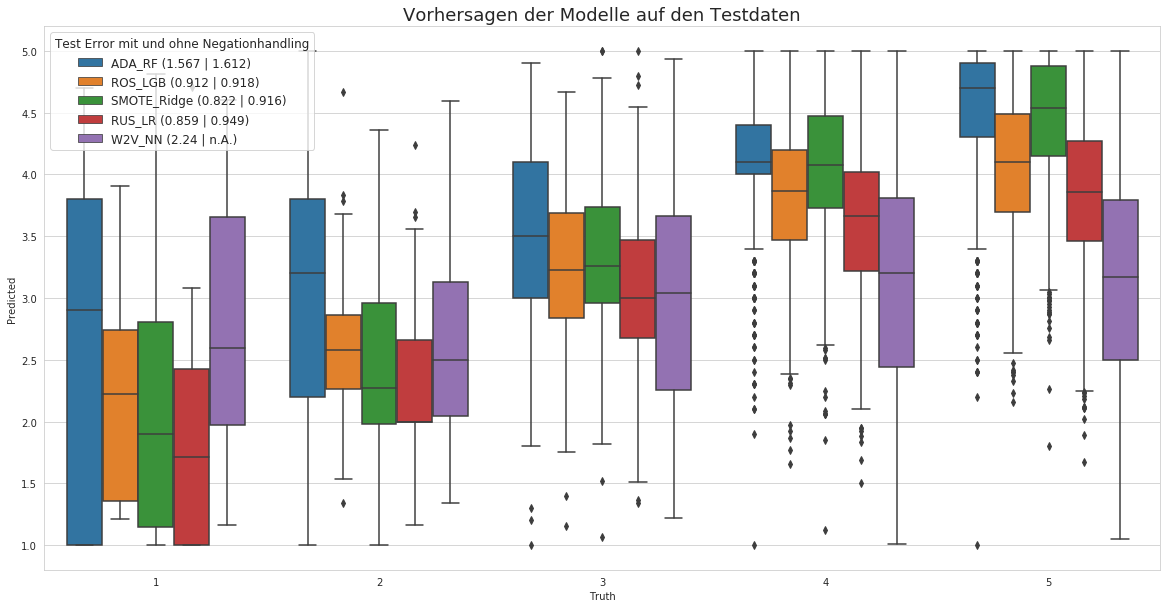

In [125]:
plot_results(y_test, [y_pred_ADA_RF, y_pred_ROS_LGB, y_pred_SMOTE_Ridge, y_pred_RUS_LR, y_pred_w2v_NN], 
                     [y_pred_ADA_RF_pp_only, y_pred_ROS_LGB_pp_only, y_pred_SMOTE_Ridge_pp_only, y_pred_RUS_LR_pp_only, y_pred_w2v_NN],
                     ["ADA_RF", "ROS_LGB","SMOTE_Ridge","RUS_LR", "W2V_NN"])

### Analysiere gefundene Parameter

hier wird geprüft ob die optimalen Parameterbelegungen Modellabhängig oder -unabhängig sind. 

In [88]:
cv_results_ROS_LGB.sort_values("rank_test_score")["params"][0]

{'reg__learning_rate': 0.1,
 'reg__max_depth': 3,
 'reg__n_estimators': 100,
 'sampl__sampling_strategy': 'auto',
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

In [89]:
cv_results_ADA_RF.sort_values("rank_test_score")["params"][0]

{'sampl__n_neighbors': 1,
 'sampl__sampling_strategy': 'auto',
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

In [90]:
cv_results_SMOTE_Ridge.sort_values("rank_test_score")["params"][0]

{'sampl__k_neighbors': 1,
 'sampl__sampling_strategy': 'auto',
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

In [91]:
cv_results_RUS_LR.sort_values("rank_test_score")["params"][0]

{'sampl__sampling_strategy': 'auto',
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

### Wo sind Modelle mit Negationshandling besser?
hier soll untersucht werden in welchen Klassen die Modelle mit Negationshandling bessere Vorhersagen liefern

ROS_LGB

In [98]:
display_metric(y_test, y_pred_ROS_LGB)

MSE for Classes:
Class 4.0: MSE:0.3315960011038691 MAE:0.4501922404225439
Class 2.0: MSE:0.7098735633281613 MAE:0.6778360952677476
Class 5.0: MSE:1.161131729422977 MAE:0.9256286872392493
Class 3.0: MSE:0.376424309251455 MAE:0.49132457667336477
Class 1.0: MSE:1.9793820319685944 MAE:1.1872131527019494

AVG MSE over Classes 0.9116815270150113
AVG MAE over Classes 0.746438950460971

Global: MAE: 0.7503700381216033 MSE 0.8571123909936138


In [99]:
display_metric(y_test, y_pred_ROS_LGB_pp_only)

MSE for Classes:
Class 4.0: MSE:0.32866129455103554 MAE:0.4580635039380524
Class 2.0: MSE:0.7307018348690323 MAE:0.7193674485252869
Class 5.0: MSE:1.2124233278087597 MAE:0.9589800253290729
Class 3.0: MSE:0.3655448541651953 MAE:0.48395369423697665
Class 1.0: MSE:1.9526474280529567 MAE:1.1582153476645463

AVG MSE over Classes 0.9179957478893959
AVG MAE over Classes 0.755716003938787

Global: MAE: 0.7726732267628998 MSE 0.886160104566294


ADA_RF

In [100]:
display_metric(y_test, y_pred_ADA_RF)

MSE for Classes:
Class 4.0: MSE:0.22440761784511784 MAE:0.33443813131313127
Class 2.0: MSE:2.112921348314607 MAE:1.1404494382022472
Class 5.0: MSE:0.40720712277413307 MAE:0.4597938144329897
Class 3.0: MSE:0.7702255639097744 MAE:0.6646616541353384
Class 1.0: MSE:4.320714285714285 MAE:1.65

AVG MSE over Classes 1.5670951877115835
AVG MAE over Classes 0.8498686076167413

Global: MAE: 0.468906235479974 MSE 0.4684567729145371


In [101]:
display_metric(y_test, y_pred_ADA_RF_pp_only)

MSE for Classes:
Class 4.0: MSE:0.23451472634508347 MAE:0.32798971861471865
Class 2.0: MSE:2.1225842696629216 MAE:1.1067415730337078
Class 5.0: MSE:0.44537540351973337 MAE:0.46704154951577626
Class 3.0: MSE:0.8200000000000001 MAE:0.6676691729323309
Class 1.0: MSE:4.437857142857142 MAE:1.6452380952380952

AVG MSE over Classes 1.612066308476976
AVG MAE over Classes 0.8429360218669257

Global: MAE: 0.4706506299202145 MSE 0.4994420580238414


SMOTE_RIDGE

In [102]:
display_metric(y_test, y_pred_SMOTE_Ridge)

MSE for Classes:
Class 4.0: MSE:0.322904810651392 MAE:0.44929241601742914
Class 2.0: MSE:0.7012413970684069 MAE:0.6023753640293821
Class 5.0: MSE:0.5387486303899935 MAE:0.5483554018546468
Class 3.0: MSE:0.5214011312608995 MAE:0.5625878999175998
Class 1.0: MSE:2.027420253143177 MAE:1.0478451291099073

AVG MSE over Classes 0.8223432445027739
AVG MAE over Classes 0.642091242185793

Global: MAE: 0.5274358804213923 MSE 0.49538106863301284


In [103]:
display_metric(y_test, y_pred_SMOTE_Ridge_pp_only)

MSE for Classes:
Class 4.0: MSE:0.2902449584319919 MAE:0.427632422712767
Class 2.0: MSE:0.8525570733462441 MAE:0.6875892627745445
Class 5.0: MSE:0.5085991826961256 MAE:0.5280464420825491
Class 3.0: MSE:0.49930913421240347 MAE:0.5414362048473162
Class 1.0: MSE:2.4294042153707602 MAE:1.133814677385647

AVG MSE over Classes 0.916022912811505
AVG MAE over Classes 0.6637038019605648

Global: MAE: 0.5105293105980929 MSE 0.4746523886957352


RUS_RF

In [106]:
display_metric(y_test, y_pred_RUS_LR)

MSE for Classes:
Class 4.0: MSE:0.5127252844102038 MAE:0.5670451432838589
Class 2.0: MSE:0.42551588173178945 MAE:0.41532631923568375
Class 5.0: MSE:1.6426817352818177 MAE:1.1334636315078095
Class 3.0: MSE:0.40679979381398396 MAE:0.47732546251331154
Class 1.0: MSE:1.305101354531947 MAE:0.806119101882471

AVG MSE over Classes 0.8585648099539483
AVG MAE over Classes 0.679855931684627

Global: MAE: 0.896403869156677 MSE 1.1842248784353402


In [108]:
display_metric(y_test, y_pred_RUS_LR_pp_only)

MSE for Classes:
Class 4.0: MSE:0.5260473146139139 MAE:0.5762568930968227
Class 2.0: MSE:0.4662574182249539 MAE:0.46350663276648424
Class 5.0: MSE:1.7443991109212658 MAE:1.1815423842516382
Class 3.0: MSE:0.3863979007330594 MAE:0.4677833667785248
Class 1.0: MSE:1.622289023789919 MAE:0.8829947242058461

AVG MSE over Classes 0.9490781536566224
AVG MAE over Classes 0.7144168002198632

Global: MAE: 0.9291070452743773 MSE 1.2518730297614902
